<a href="https://colab.research.google.com/github/DrYGuo/EELS-aberration-measurements-and-simulations/blob/main/Copy_of_EELS_Aberration_simulations_using_Hamish_pySTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/HamishGBrown/py_multislice

Cloning into 'py_multislice'...
remote: Enumerating objects: 760, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 760 (delta 0), reused 1 (delta 0), pack-reused 753
Receiving objects: 100% (760/760), 12.64 MiB | 20.48 MiB/s, done.
Resolving deltas: 100% (514/514), done.


In [ ]:
import sys
sys.path.append('/content/py_multislice/pyms/utils')

In [ ]:
from numpy_utils import q_space_array

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pwd
%cd py_multislice/
#install dependencies using the following line
!pip install -e.

/content
/content/py_multislice
Obtaining file:///content/py_multislice
     |████████████████████████████████| 76 kB 2.5 MB/s 
     |████████████████████████████████| 2.2 MB 30.9 MB/s 
     |████████████████████████████████| 649 kB 41.9 MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-py3-none-any.whl size=67177 sha256=b76ad6997901528fabe602558cb44cb067e8eb3a45426a6b73ffb392d454f739
  Stored in directory: /root/.cache/pip/wheels/54/64/43/dfd10cf95dc1687dc5350e861321ecd9a5d76b7c3d96fa1dc6
Successfully built pypng
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Running setup.py develop for pyms


In [ ]:
"""Functions for emulating electron optics of a TEM."""

import numpy as np
import copy
from numpy_utils import q_space_array


class aberration:
    """A class describing electron lens aberrations."""

    def __init__(self, Krivanek, Haider, Description, amplitude, angle, n, m):
        """
        Intialize the lens aberration object.
        Parameters
        ----------
        Krivanek : str
            A string describing the aberration coefficient in Krivanek notation
            (C_mn)
        Haider : str
            A string describing the aberration coefficient in Haider notation
            (ie. A1, A2, B2)
        Description : str
            A string describing the colloqiual name of the aberration ie. 2-fold
            astig.
        amplitude : float
            The amplitude of the aberration in Angstrom
        angle : float
            The angle of the aberration in radians
        n : int
            The principle aberration order
        m : int
            The rotational order of the aberration.
        """
        self.Krivanek = Krivanek
        self.Haider = Haider
        self.Description = Description
        self.amplitude = amplitude
        self.m = m
        self.n = n
        if m > 0:
            self.angle = angle # This angle is not very consistent with the convention in NION. Here Cnm cos(m*(phi-angle)) is used instead of Cnma cos(m*phi)+Cnmb sin(m*phi)
        else:
            self.angle = 0


    def __str__(self):
        """Return a string describing the aberration."""
        if self.m > 0:
            return (
                "{0:17s} ({1:2s}) -- {2:3s} = {3:9.2e} \u00E5 \u03B8 = "
                + "{4:4d}\u00B0 "
            ).format(
                self.Description,
                self.Haider,
                self.Krivanek,
                self.amplitude,
                int(np.rad2deg(self.angle)),
            )
        else:
            return " {0:17s} ({1:2s}) -- {2:3s} = {3:9.2e} \u00E5".format(
                self.Description, self.Haider, self.Krivanek, self.amplitude
            )
    
# functions below

def aberration_starter_pack():
    """Create the set of aberrations up to fifth order. YG: All the units should be in Angstrom """
    aberrations = []
    aberrations.append(aberration("C10", "C1", "Defocus        ",   0.0, 0.0, 1, 0)) # Cnm_amplitude, Cnm_phase, n, m
    aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", 0.0, 0.0, 1, 2))
    aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", 0.0, 0.0, 2, 3))
    aberrations.append(aberration("C21", "B2", "Axial coma       ", 5000.0, 5000.0, 2, 1))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", 0.0, 0.0, 3, 0))
    aberrations.append(aberration("C34", "A3", "4-Fold astig.    ", 0.0, 0.0, 3, 4))
    aberrations.append(aberration("C32", "S3", "Axial star aber. ", 0.0, 0.0, 3, 2))
    aberrations.append(aberration("C45", "A4", "5-Fold astig.    ", 0.0, 0.0, 4, 5))
    aberrations.append(aberration("C43", "D4", "3-Lobe aberr.    ", 0.0, 0.0, 4, 3))
    aberrations.append(aberration("C41", "B4", "4th order coma   ", 0.0, 0.0, 4, 1))
    aberrations.append(aberration("C50", "C5", "5th order spher. ", 0.0, 0.0, 5, 0))
    aberrations.append(aberration("C56", "A5", "6-Fold astig.    ", 0.0, 0.0, 5, 6))
    aberrations.append(aberration("C52", "S5", "5th order star   ", 0.0, 0.0, 5, 2))
    aberrations.append(aberration("C54", "R5", "5th order rosette", 0.0, 0.0, 5, 4))
    return aberrations


def chi(q, qphi, lam, df=0.0, aberrations=[]):
    r"""
    Calculate the aberration function, chi.
    Parameters
    ----------
    q : float or array_like
        Reciprocal space extent (Inverse angstroms).
    qphi : float or array_like
        Azimuth of grid in radians
    lam : float
        Wavelength of electron (Inverse angstroms).
    df : float, optional
        Defocus in Angstrom
    aberrations : list, optional
        A list containing a set of the class aberration, pass an empty list for
        an unaberrated contrast transfer function.
    Returns
    -------
    chi : float or array_like
        The aberration function, will be the same shape as `q`. This is used to
        calculate the probe wave function in reciprocal space.
    """
    qlam = q * lam
    chi_ = qlam ** 2 / 2 * df
    for ab in aberrations:
        chi_ += (
            qlam ** (ab.n + 1)
            * float(ab.amplitude)
            / (ab.n + 1)
            * np.cos(ab.m * (qphi - float(ab.angle)))
        )
    return 2 * np.pi * chi_ / lam


For EELS, the chi function needs to be re-written

In [ ]:
def chi_2(q,lam,df=0):
    E10=10000
    E01=-100
    E20=2000
    E11=-400
    E02=200
    E30=0
    E12=0
    E21=0
    E03=0
    
    '''
    In this notation, qlam is a vector, qlam[1] is in x direction (dispersive direction) and qlam[0] is in y direction
    '''

     # qlam is just theta
    x=q[1]*lam # x means thetax
    y=q[0]*lam

    chi_=0 #initialize with some defocus


    chi_=chi_+(E10/2)*x**2 + E01 *x*y +(E20/3) *x**3 + (E11/2)* x**2 *y + E02* x* y**2 + (E30/4)* x**4 + (E12/2)* x**2*y**2 + (E21/3)*x**3*y + E03* x* y**3

    return 2 * np.pi * chi_ /lam  


In [ ]:
print(chi_2([0.01,0.01],0.0002,df=0))

0.0006157523276552078


In [ ]:
def make_contrast_transfer_function_2(
    pix_dim,
    real_dim,
    eV,
    app,
    optic_axis=[0, 0],
    aperture_shift=[0, 0],
    tilt_units="mrad",
    df=100,
    aberrations=[],
    q=None,
    app_units="mrad",
):
    """
    Make an electron lens contrast transfer function.
    Parameters
    ---------
    pix_dim : (2,) int array_like
        The pixel size of the grid
    real_dim : (2,) float array_like
        The size of the grid in Angstrom
    eV : float
        The energy of the probe electrons in eV
    app : float or None
        The aperture in units specified by app_units, pass `app` = None for
        no aperture
    optic_axis : (2,) array_like, optional
        allows the user to specify a different optic axis in units specified by
        `tilt_units`
    aperture_shift : (2,) array_like, optional
        Shift of the objective aperture relative to the center of the array
    tilt_units : string
        Units of the `optic_axis` or `aperture_shift` values, default is mrad
    df : float
        Probe defocus in A, a negative value indicate overfocus
    aberrations : array_like of aberration objects
        List containing instances of class aberration
    q :
        Precomputed reciprocal space array, allows the user to reduce
        computation time somewhat
    app_units : string
        The units of `app` (A^-1 or mrad)
    Returns
    -------
    ctf : array_like
        The lens contrast transfer function in reciprocal space
    """
    # Make reciprocal space array
    if q is None:
        q = q_space_array(pix_dim, real_dim[:2])

    # Get  electron wave number (inverse of wavelength)
    k = wavev(eV)

    # Convert tilts to units of inverse Angstrom                               
    optic_axis_ = convert_tilt_angles(
        optic_axis, tilt_units, real_dim, eV, invA_out=True
    )
    aperture_shift_ = convert_tilt_angles(
        aperture_shift, tilt_units, real_dim, eV, invA_out=True
    )

    if app is None:
        app_ = np.amax(np.abs(q))
    else:
        # Get aperture size in units of inverse Angstrom
        app_ = convert_tilt_angles(app, app_units, real_dim, eV, invA_out=True)

    # Initialize the array to contain the CTF
    CTF = np.zeros(pix_dim, dtype=np.complex)

    # Calculate the magnitude of the reciprocal lattice grid
    # qarray1 accounts for a shift of the optic axis
    qarray1 = np.sqrt(
        np.square(q[0] - optic_axis_[0]) + np.square(q[1] - optic_axis_[1])
    )

    # qarray2 accounts for a shift of both the optic axis and the aperture                Is the square root missing?
    qarray2 = np.sqrt(np.square(q[0] - optic_axis_[0] - aperture_shift_[0]) + np.square(                 #  tilt optic axis and shift aperture are equivalent
        q[1] - optic_axis_[1] - aperture_shift_[1]))

    # Calculate azimuth of reciprocal space array in case it is required for
    # aberrations
    qphi = np.arctan2(q[0] - optic_axis_[0], q[1] - optic_axis_[1])

    # Only calculate CTF for region within the aperture
    mask = qarray2 <= app_ 
    
    print(q[0].shape)

    print(mask)

    print('normalization constant')
    print(np.count_nonzero(mask))

    print('qarray shape')
    print(qarray1.shape)
    print(np.array(q[0][mask]).shape)

    # print(np.where(mask2==1)[1][:].shape)
    print('what is up')
    CTF[mask] = np.exp(-1j *chi_2([np.array(q[0][mask]),np.array(q[1][mask])],1.0 / k,df=0)) # confused with the sign convention here it seems that the minus sign is consistent with FFT with exp(+i2pix)
    print(CTF.shape)
    return CTF

End of make_contrast_function_2

In [ ]:
def chi(q, qphi, lam, df=0.0, aberrations=[]):
    r"""
    Calculate the aberration function, chi.
    Parameters
    ----------
    q : float or array_like
        Reciprocal space extent (Inverse angstroms).
    qphi : float or array_like
        Azimuth of grid in radians
    lam : float
        Wavelength of electron (Inverse angstroms).
    df : float, optional
        Defocus in Angstrom
    aberrations : list, optional
        A list containing a set of the class aberration, pass an empty list for
        an unaberrated contrast transfer function.
    Returns
    -------
    chi : float or array_like
        The aberration function, will be the same shape as `q`. This is used to
        calculate the probe wave function in reciprocal space.
    """
    qlam = q * lam # dimensionless
    chi_ = qlam ** 2 / 2 * df
    print(aberrations[2].n)
    print(aberrations[2].amplitude)

    for ab in aberrations:
        chi_ += (
            qlam ** (ab.n + 1)
            * float(ab.amplitude)
            / (ab.n + 1)
            * np.cos(ab.m * (qphi - float(ab.angle)))
        )
    return 2 * np.pi * chi_ / lam    

In [ ]:
chi_result=chi(0.01,0.01,0.0025,1,aberrations=aberration_starter_pack())
print(chi_result)

2
0.0
7.948740690178739e-07


In [ ]:
def make_contrast_transfer_function(
    pix_dim,
    real_dim,
    eV,
    app,
    optic_axis=[0, 0],
    aperture_shift=[0, 0],
    tilt_units="mrad",
    df=100,
    aberrations=[],
    q=None,
    app_units="mrad",
):
    """
    Make an electron lens contrast transfer function.
    Parameters
    ---------
    pix_dim : (2,) int array_like
        The pixel size of the grid
    real_dim : (2,) float array_like
        The size of the grid in Angstrom
    eV : float
        The energy of the probe electrons in eV
    app : float or None
        The aperture in units specified by app_units, pass `app` = None for
        no aperture
    optic_axis : (2,) array_like, optional
        allows the user to specify a different optic axis in units specified by
        `tilt_units`
    aperture_shift : (2,) array_like, optional
        Shift of the objective aperture relative to the center of the array
    tilt_units : string
        Units of the `optic_axis` or `aperture_shift` values, default is mrad
    df : float
        Probe defocus in A, a negative value indicate overfocus
    aberrations : array_like of aberration objects
        List containing instances of class aberration
    q :
        Precomputed reciprocal space array, allows the user to reduce
        computation time somewhat
    app_units : string
        The units of `app` (A^-1 or mrad)
    Returns
    -------
    ctf : array_like
        The lens contrast transfer function in reciprocal space
    """
    # Make reciprocal space array
    if q is None:
        q = q_space_array(pix_dim, real_dim[:2])

    # Get  electron wave number (inverse of wavelength)
    k = wavev(eV)

    # Convert tilts to units of inverse Angstrom                               
    optic_axis_ = convert_tilt_angles(
        optic_axis, tilt_units, real_dim, eV, invA_out=True
    )
    aperture_shift_ = convert_tilt_angles(
        aperture_shift, tilt_units, real_dim, eV, invA_out=True
    )

    if app is None:
        app_ = np.amax(np.abs(q))
    else:
        # Get aperture size in units of inverse Angstrom
        app_ = convert_tilt_angles(app, app_units, real_dim, eV, invA_out=True)

    # Initialize the array to contain the CTF
    CTF = np.zeros(pix_dim, dtype=np.complex)

    # Calculate the magnitude of the reciprocal lattice grid
    # qarray1 accounts for a shift of the optic axis
    qarray1 = np.sqrt(
        np.square(q[0] - optic_axis_[0]) + np.square(q[1] - optic_axis_[1])
    )

    # qarray2 accounts for a shift of both the optic axis and the aperture                Is the square root missing?
    qarray2 = np.sqrt(np.square(q[0] - optic_axis_[0] - aperture_shift_[0]) + np.square(                 #  tilt optic axis and shift aperture are equivalent
        q[1] - optic_axis_[1] - aperture_shift_[1]))

    # Calculate azimuth of reciprocal space array in case it is required for
    # aberrations
    qphi = np.arctan2(q[0] - optic_axis_[0], q[1] - optic_axis_[1])

    # Only calculate CTF for region within the aperture
    mask = qarray2 <= app_ 
    plt.imshow(mask)
    print('mask shape')
    print(mask[mask].shape)
    print('normalization constant')
    print(np.count_nonzero(mask))
    plt.colorbar()
    print('qarray2 shape')
    print(qarray2.shape)
    print('masked qarray2 shape')
    print(qarray2[mask].shape)
    print(qarray2[mask].min(),qarray1.min())
    CTF[mask] = np.exp(-1j * chi(qarray2[mask], qphi[mask], 1.0 / k, df, aberrations)) # confused with the sign convention here it seems that the minus sign is consistent with FFT with exp(+i2pix)
    return CTF


def focused_probe(
    gridshape,
    rsize,
    eV,
    app,
    beam_tilt=[0, 0],
    aperture_shift=[0, 0],
    tilt_units="mrad",
    df=0,
    aberrations=[],
    q=None,
    app_units="mrad",
    qspace=False,
):
    """
    Make a focused electron probe wave function.
    Parameters
    ---------
    gridshape : (2,) array_like
        The pixel size of the grid
    rsize : (2,) array_like
        The size of the grid in Angstrom
    eV : float
        The energy of the probe electrons in electron volts
    app : float
        The probe-forming apperture in units specified by app_units, pass None
        if no probe forming aperture is to be used
    beam_tilt : array_like, optional
        Allows the user to simulate a (small < 50 mrad) beam tilt. To maintain
        periodicity of the wave function at the boundaries this tilt is rounded
        to the nearest pixel value.
    aperture_shift : array_like, optional
        Allows the user to simulate a (small < 50 mrad) aperture shift. To
        maintain periodicity of the wave function at the boundaries this tilt
        is rounded to the nearest pixel value.
    tilt_units : string, optional
        Units of beam tilt and aperture shift, can be 'mrad','pixels' or 'invA'
    df : float, optional
        Probe defocus in A, a negative value indicate overfocus
    aberrations : list, optional
        A list of of probe aberrations of class pyms.Probe.aberration, pass an
        empty list for an un-aberrated probe
    app_units : string, optional
        The units of the aperture size ("invA", "pixels" or "mrad")
    qspace : bool, optional
        If True return the probe in reciprocal space
    Returns
    -------
    probe : complex (Y,X) np.ndarray
        The requested electron probe wave function
    """
    probe = make_contrast_transfer_function(
        gridshape,
        rsize,
        eV,
        app,
        beam_tilt,
        aperture_shift,
        tilt_units,
        df,
        aberrations,
        q,
        app_units,
    )

    # Normalize the STEM probe so that its sum-squared intensity is unity
    probe *= np.sqrt(np.prod(gridshape)) / np.sqrt(np.sum(np.square(np.abs(probe))))

    # Return real or diffraction space probe depending on user preference
    if not qspace:
        return np.fft.ifft2(probe)
    return probe


def plane_wave_illumination(
    gridshape, gridsize, eV, tilt=[-10, -10], tilt_units="mrad", qspace=False
):
    """
    Generate plane wave illumination for input to multislice.
    The wave function will be normalized such that sum of intensity is unity in
    real space.
    Parameters
    ----------
    gridshape : (2,) array_like
        Pixel dimensions of the 2D grid
    gridsize : (2,) array_like
        Size of the grid in real space
    eV : float
        Probe energy in electron volts (irrelevant for untilted illumination)
    tilt : array_like, optional
        Allows the user to simulate a (small < 50 mrad) beam tilt, To maintain
        periodicity of the wave function at the boundaries this tilt is rounded
        to the nearest pixel value.
    tilt_units : string, optional
        Units of beam tilt, can be 'mrad','pixels' or 'invA'
    qspace : bool, optional
        Pass qspace = True to get the probe in momentum (q) space
    Returns
    ------
    illum : np.ndarray (Y,X)
    """
    # Initialize array that contains wave function
    illum = np.zeros(gridshape, dtype=np.complex)

    # Convert tilt to units of pixels
    tilt_ = convert_tilt_angles(tilt, tilt_units, gridsize, eV)

    # Case of an untilted plane wave (phase is zero everywhere)
    if tilt[0] == 0 and tilt[1] == 0:
        illum[:, :] = 1 / np.sqrt(np.product(gridshape))

        if qspace:
            return np.fft.fft2(illum)
        else:
            return illum

    # Set the value of wavefunction amplitude such that after inverse Fourier
    # transform (and resulting division by the total number of pixels) the sum
    # of intensity will be 1
    illum[tilt_[0], tilt_[1]] = np.sqrt(np.product(gridshape))

    # Return wave function in real space
    if qspace:
        return illum
    else:
        return np.fft.ifft2(illum)


def wavev(E):
    """
    Evaluate the relativistically corrected wavenumber of an electron with energy E.
    Energy E must be in electron-volts, see Eq. (2.5) in Kirkland's Advanced
    Computing in electron microscopy
    """
    # Planck's constant times speed of light in eV Angstrom
    hc = 1.23984193e4
    # Electron rest mass in eV
    m0c2 = 5.109989461e5
    return np.sqrt(E * (E + 2 * m0c2)) / hc


def relativistic_mass_correction(E):
    """
    Evaluate the relativistic mass correction for electron with energy E in eV.
    See Eq. (2.2) in Kirkland's Advanced Computing in electron microscopy.
    """
    # Electron rest mass in eV
    m0c2 = 5.109989461e5
    return (m0c2 + E) / m0c2

In [ ]:
def convert_tilt_angles(tilt, tilt_units, rsize, eV, invA_out=False):
    """
    Convert  tilt to pixel or inverse Angstroms units regardless of input units.
    Input units can be mrad, pixels or inverse Angstrom
    Parameters
    ----------
    tilt : array_like
        Tilt in units of mrad, pixels or inverse Angstrom
    tilt_units : string
        Units of specimen and beam tilt, can be 'mrad','pixels' or 'invA'
    rsize : (2,) array_like
        The size of the grid in Angstrom
    eV : float
        Probe energy in electron volts
    invA_out : bool
        Pass True if inverse Angstrom units are desired.
    """
    # If units of the tilt are given in mrad, convert to inverse Angstrom
    if tilt_units == "mrad":
        k = wavev(eV)
        tilt_ = np.asarray(tilt) * 1e-3 * k
    else:
        tilt_ = tilt

    # If inverse Angstroms are requested our work here is done
    if invA_out:
        return tilt_

    # Convert inverse Angstrom to pixel coordinates, this will be rounded
    # to the nearest pixel
    if tilt_units != "pixels":
        tilt_ = np.round(tilt_ * rsize[:2]).astype(int)
    return tilt_

In [ ]:
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [ ]:
real_dim=[51.2,51.2]

In [ ]:
real_dim[:2]

[51.2, 51.2]

mask shape
(3125,)
normalization constant
3125
qarray2 shape
(256, 256)
masked qarray2 shape
(3125,)
0.0 0.0
2
0.0


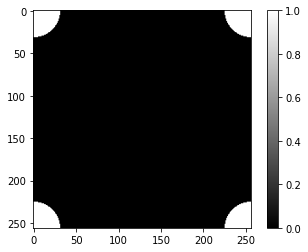

In [ ]:
Transfer_function=make_contrast_transfer_function(pix_dim=[256,256],real_dim=[51.2,51.2],eV=6e4,app=30,optic_axis=[0,0],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')

In [ ]:
Transfer_function_shift=np.fft.fftshift(Transfer_function)
Transfer_function_shift.shape

(256, 256)

[[1.        -0.00000000e+00j 1.        -2.85742815e-05j
  0.99999997-2.28594250e-04j ... 0.9999997 +7.71505525e-04j
  0.99999997+2.28594250e-04j 1.        +2.85742815e-05j]
 [0.99999998+1.82522286e-04j 0.99999995+3.07896005e-04j
  0.9999998 +6.26868577e-04j ... 0.9999964 +2.68244810e-03j
  0.99999928+1.19835396e-03j 0.99999991+4.22193124e-04j]
 [0.99999893+1.46017777e-03j 0.99999858+1.68235067e-03j
  0.99999697+2.46316559e-03j ... 0.99998283+5.85994289e-03j
  0.9999943 +3.37753867e-03j 0.99999806+1.96809300e-03j]
 ...
 [0.99998786-4.92808179e-03j 0.9999834 -5.76137954e-03j
  0.9999691 -7.86121953e-03j ... 0.99996545-8.31309652e-03j
  0.99997968-6.37539467e-03j 0.99998653-5.18990248e-03j]
 [0.99999893-1.46017777e-03j 0.99999806-1.96809300e-03j
  0.9999943 -3.37753867e-03j ... 0.99999341-3.63117449e-03j
  0.99999697-2.46316559e-03j 0.99999858-1.68235067e-03j]
 [0.99999998-1.82522286e-04j 0.99999991-4.22193124e-04j
  0.99999928-1.19835396e-03j ... 0.99999953-9.67994269e-04j
  0.9999998 -6

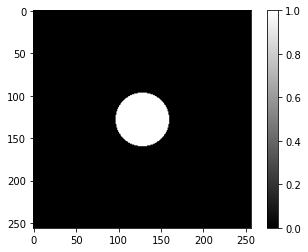

In [ ]:
Transfer_function.shape
print(Transfer_function)
plt.imshow(abs(Transfer_function_shift))
plt.colorbar()

### To calculate the EELS, just Fourier transform the contrast transfer function into real space in one dimension
See projection-slice theorem from https://en.wikipedia.org/wiki/Projection-slice_theorem

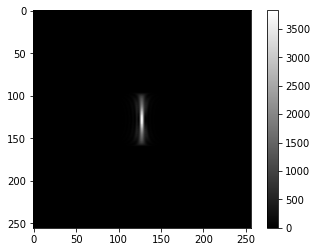

In [ ]:
plt.set_cmap('gray')
EELS_Transfer_function_real=np.fft.fftshift(np.fft.fft(Transfer_function,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
I_EELS_real=EELS_Transfer_function_real*np.conjugate(EELS_Transfer_function_real) # can be dived by the 
plt.imshow(abs(I_EELS_real))
plt.colorbar()

Gaussian smooth to account for partial coherence?

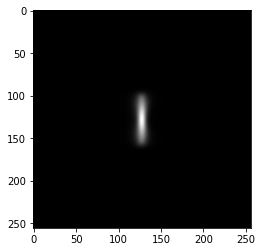

In [ ]:
import scipy.ndimage
plt.imshow(scipy.ndimage.gaussian_filter(abs(I_EELS_real),sigma=3))

If there's no aberration, tilting the beam doesn't move the beam in x direction but only in y

Summed intensity profile of ZLP

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


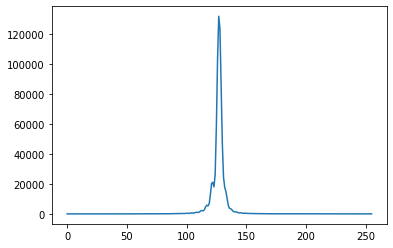

In [ ]:
plt.plot(np.sum(I_EELS_real,axis=0))

0.0


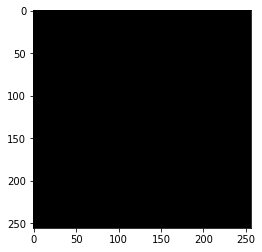

In [ ]:
plt.imshow(np.imag(I_EELS_real))
print(np.imag(I_EELS_real).max())
# it looks that the intensity is truely real! no imaginary part

Transfer function in real space (Probe shape)

Tilting the beam doesn't move the probe in real space if there's not aberration

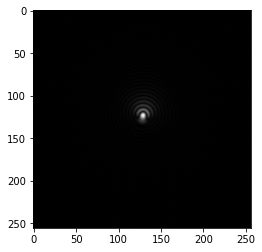

In [ ]:
plt.set_cmap('gray')
Transfer_function_real=np.fft.fftshift(np.fft.ifft2(Transfer_function))
plt.imshow(abs(Transfer_function_real))


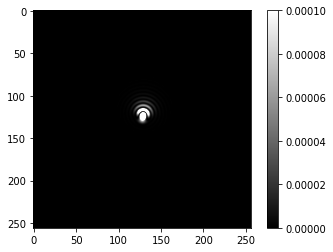

In [ ]:
I_real=Transfer_function_real*np.conjugate(Transfer_function_real)
plt.imshow(abs(I_real),vmax=0.0001)
plt.colorbar()


Text(0.5, 1.0, 'Line profile')

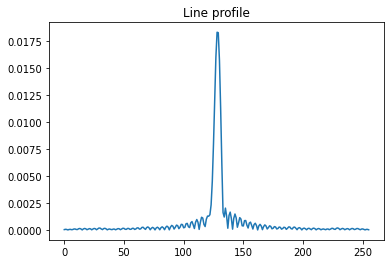

In [ ]:
plt.plot(abs(Transfer_function_real[127,:]))
plt.title('Line profile')

Use the aberration coefficients for EELS

In [ ]:
Transfer_function_2=make_contrast_transfer_function_2(pix_dim=[2048,2048],real_dim=[26.1,4136.96],eV=6e4,app=30,optic_axis=[0,0],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')

(2048, 2048)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
normalization constant
64168
qarray shape
(2048, 2048)
(64168,)
what is up
(2048, 2048)


In [ ]:
Transfer_function2_shift=np.fft.fftshift(Transfer_function_2)
Transfer_function2_shift.shape
print(Transfer_function_2.dtype)
# plt.imshow(abs(Transfer_function2_shift))
# plt.colorbar()

complex128


<Figure size 432x288 with 0 Axes>

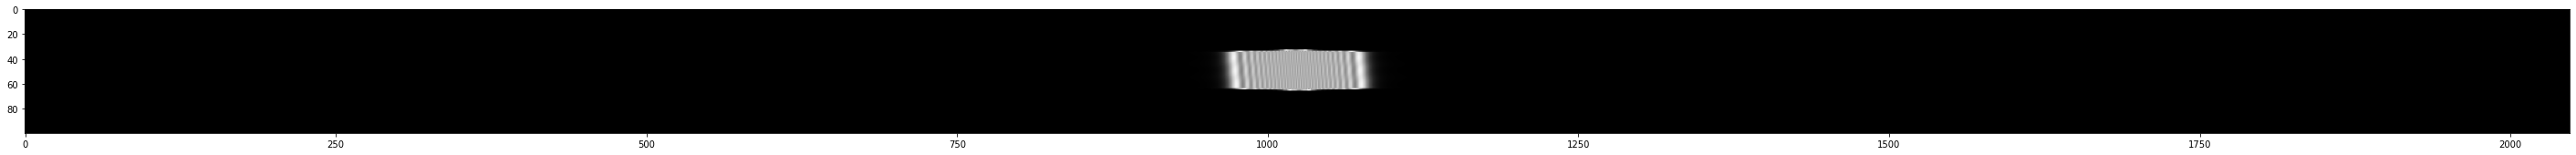

In [ ]:
plt.set_cmap('gray')
EELS_Transfer_function_real_2=np.fft.fftshift(np.fft.fft(Transfer_function_2,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
I_EELS_real_2=EELS_Transfer_function_real_2*np.conjugate(EELS_Transfer_function_real_2) # can be dived by the 
plt.figure(figsize=(50,100))
plt.imshow(abs(I_EELS_real_2)[975:1075,:])
# plt.colorbar()


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


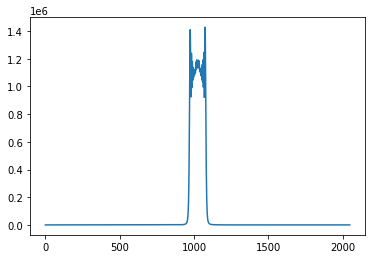

In [ ]:
 plt.plot(np.sum(I_EELS_real_2,axis=0))

generate a tilt series and get the aberration pattern

In [ ]:
tilt_range_y=np.array([-19.56,-9.78,0,9.78,19.56])
tilt_range_x=np.array([-19.56,-9.78,0,9.78,19.56])

num=tilt_range_x.shape[0]*tilt_range_y.shape[0]

aberration_pattern=np.zeros((tilt_range_x.shape[0],tilt_range_y.shape[0],256,256))
aberration_pattern_sum=np.zeros((256,256))
print(aberration_pattern.shape)

for i,tilty in enumerate(tilt_range_y):
  for j,tiltx in enumerate(tilt_range_x):
      Transfer_function_2=make_contrast_transfer_function_2(pix_dim=[256,256],real_dim=[51.2,51.2],eV=6e4,app=3.03,optic_axis=[tiltx*np.cos(np.pi/4)-tilty*np.sin(np.pi/4),tiltx*np.sin(np.pi/4)+tilty*np.cos(np.pi/4)],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')
      EELS_Transfer_function_real_2=np.fft.fftshift(np.fft.fft(Transfer_function_2,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
      aberration_pattern[i,j,:,:]=abs(EELS_Transfer_function_real_2*np.conjugate(EELS_Transfer_function_real_2))
      aberration_pattern_sum+=aberration_pattern[i,j,:,:]


(5, 5, 256, 256)
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
33
qarray shape
(256, 256)
(33,)
what is up
(256, 256)
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
32
qarray shape
(256, 256)
(32,)
what is up
(256, 256)
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
no

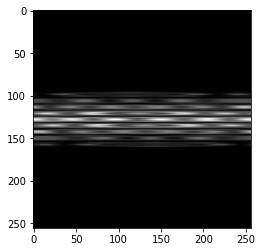

In [ ]:
plt.imshow(aberration_pattern_sum)

Calibrating the EELS image

In [ ]:
tilt_range_y=np.array([-19.56,-9.78,0,9.78,19.56])
tilt_range_x=np.array([-19.56,-9.78,0,9.78,19.56])

num=tilt_range_x.shape[0]*tilt_range_y.shape[0]

aberration_pattern=np.zeros((tilt_range_x.shape[0],tilt_range_y.shape[0],2048,2048))
aberration_pattern_sum=np.zeros((2048,2048))
print(aberration_pattern.shape)

for i,tilty in enumerate(tilt_range_y):
  for j,tiltx in enumerate(tilt_range_x):
      Transfer_function_2=make_contrast_transfer_function_2(pix_dim=[2048,2048],real_dim=[25.558,4136.96],eV=6e4,app=3.03,optic_axis=[tiltx*np.cos(np.pi/4)-tilty*np.sin(np.pi/4),tiltx*np.sin(np.pi/4)+tilty*np.cos(np.pi/4)],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')
      EELS_Transfer_function_real_2=np.fft.fftshift(np.fft.fft(Transfer_function_2,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
      aberration_pattern[i,j,:,:]=abs(EELS_Transfer_function_real_2*np.conjugate(EELS_Transfer_function_real_2))
      aberration_pattern_sum+=aberration_pattern[i,j,:,:]

(5, 5, 2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False Fals

In [ ]:
tilt_range_y=np.array([-19.56,-9.78,0,9.78,19.56])
tilt_range_x=np.array([-19.56,-9.78,0,9.78,19.56])

num=tilt_range_x.shape[0]*tilt_range_y.shape[0]

aberration_pattern=np.zeros((tilt_range_x.shape[0],tilt_range_y.shape[0],2048,2048))
aberration_pattern_sum=np.zeros((2048,2048))
print(aberration_pattern.shape)

for i,tilty in enumerate(tilt_range_y):
  for j,tiltx in enumerate(tilt_range_x):
      Transfer_function_2=make_contrast_transfer_function_2(pix_dim=[2048,2048],real_dim=[4136.96,4136.96],eV=6e4,app=3.03,optic_axis=[tiltx*np.cos(np.pi/4)-tilty*np.sin(np.pi/4),tiltx*np.sin(np.pi/4)+tilty*np.cos(np.pi/4)],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')
      EELS_Transfer_function_real_2=np.fft.fftshift(np.fft.fft(Transfer_function_2,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
      aberration_pattern[i,j,:,:]=abs(EELS_Transfer_function_real_2*np.conjugate(EELS_Transfer_function_real_2))
      aberration_pattern_sum+=aberration_pattern[i,j,:,:]

(5, 5, 2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False Fals

In [ ]:
tilt_range_y=np.array([-19.56,-9.78,0,9.78,19.56])
tilt_range_x=np.array([-19.56,-9.78,0,9.78,19.56])

num=tilt_range_x.shape[0]*tilt_range_y.shape[0]

aberration_pattern=np.zeros((tilt_range_x.shape[0],tilt_range_y.shape[0],2048,2048))
aberration_pattern_sum=np.zeros((2048,2048))
print(aberration_pattern.shape)

for i,tilty in enumerate(tilt_range_y):
  for j,tiltx in enumerate(tilt_range_x):
      Transfer_function_2=make_contrast_transfer_function_2(pix_dim=[2048,2048],real_dim=[26.61,4136.96],eV=6e4,app=3.03,optic_axis=[tiltx*np.cos(np.pi/4)-tilty*np.sin(np.pi/4),tiltx*np.sin(np.pi/4)+tilty*np.cos(np.pi/4)],aperture_shift=[0,0],tilt_units='mrad',df=0,aberrations=aberration_starter_pack(),q=None,app_units='mrad')
      EELS_Transfer_function_real_2=np.fft.fftshift(np.fft.fft(Transfer_function_2,axis=-1)) # although this should be a Forward FFT, the sign convention tries to follow Kirkland's book which has the opposite sign for FFT in numpy
      aberration_pattern[i,j,:,:]=abs(EELS_Transfer_function_real_2*np.conjugate(EELS_Transfer_function_real_2))
      aberration_pattern_sum+=aberration_pattern[i,j,:,:]

(5, 5, 2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
normalization constant
0
qarray shape
(2048, 2048)
(0,)
what is up
(2048, 2048)
(2048, 2048)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False Fals

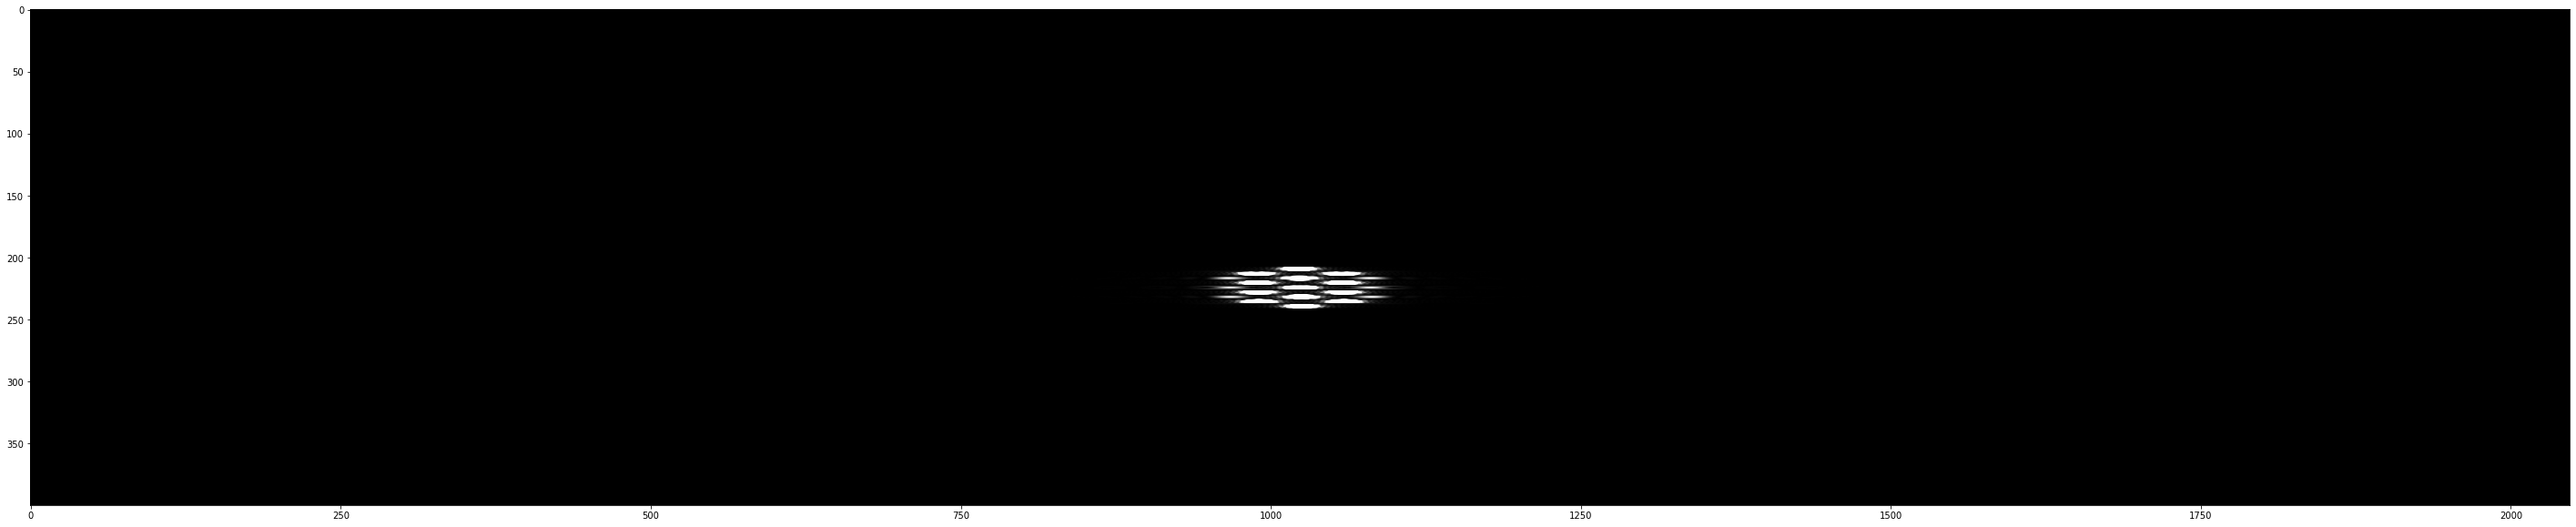

In [ ]:
plt.figure(figsize=(50,100))
plt.imshow(aberration_pattern_sum[800:1200,:],vmax=10000)
# plt.colorbar()
